You might have to install `pytorch`, I recommend googling as I had to run a pretty complex code on the terminal.
The following code are from: https://realpython.com/generative-adversarial-networks/

In [1]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt

Just setting a random state.

In [2]:
torch.manual_seed(111)

Making some data points, results should be a sine wave

I thinking this is where we substitute in our time series data where x axis would be time and y axis is what ever value we're trying to generate

In [3]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

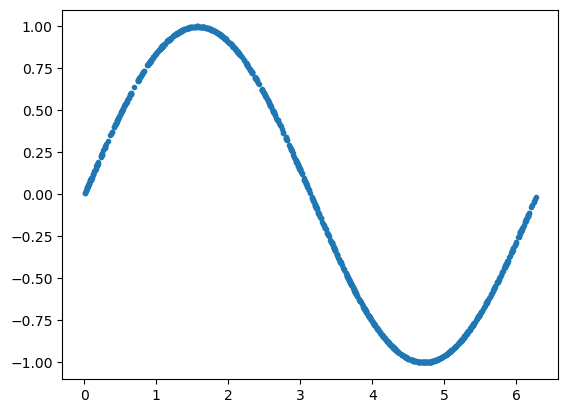

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

Shuffles the data from `train_set` and return batches of 32 samples that we use to train the neural network

In [5]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

Implement Discriminator

This is where it gets complicated coding wise, I'm not sure how much modifying we'll have to do here. Recommend reading the blog post to see what each line means.

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
discriminator = Discriminator()

Implement Generator

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

Setting some parameter here

`lr` learning rate

`num_epoch` number of repetitions of training

`loss_function` specifying the loss function to train the models

In [9]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

Using the `Adam` algorithm for training. Might have to read into other algorithms, not too clear what this is.

In [10]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

This is the training loop

In [11]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.21308740973472595
Epoch: 0 Loss G.: 1.7989580631256104
Epoch: 10 Loss D.: 0.6099680662155151
Epoch: 10 Loss G.: 0.9077383875846863
Epoch: 20 Loss D.: 0.620063066482544
Epoch: 20 Loss G.: 0.953209638595581
Epoch: 30 Loss D.: 0.6286342144012451
Epoch: 30 Loss G.: 0.9838343262672424
Epoch: 40 Loss D.: 0.6698883175849915
Epoch: 40 Loss G.: 0.7054421901702881
Epoch: 50 Loss D.: 0.6472947001457214
Epoch: 50 Loss G.: 0.7536922097206116
Epoch: 60 Loss D.: 0.6895328164100647
Epoch: 60 Loss G.: 0.7573033571243286
Epoch: 70 Loss D.: 0.6916728615760803
Epoch: 70 Loss G.: 0.6852325201034546
Epoch: 80 Loss D.: 0.6521215438842773
Epoch: 80 Loss G.: 0.7162517309188843
Epoch: 90 Loss D.: 0.7148057222366333
Epoch: 90 Loss G.: 0.6529541611671448
Epoch: 100 Loss D.: 0.6874293088912964
Epoch: 100 Loss G.: 0.6776154637336731
Epoch: 110 Loss D.: 0.7406155467033386
Epoch: 110 Loss G.: 0.7122131586074829
Epoch: 120 Loss D.: 0.593325674533844
Epoch: 120 Loss G.: 1.1042335033416748
Epoch: 130

Using the generator to generate some sample points and plotting them

In [12]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

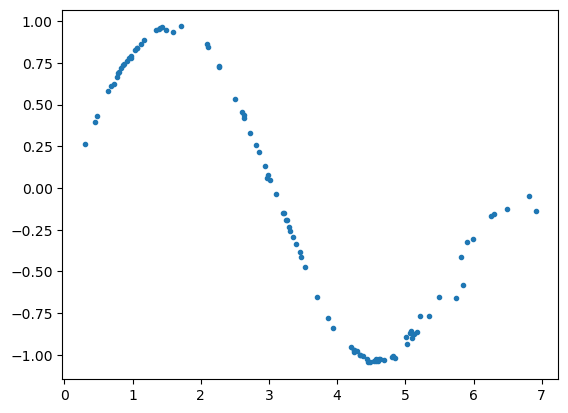

In [13]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

Evolution of the generated data points
![Alt Text](https://files.realpython.com/media/fig_gan_x1x2.69b1d6021da8.gif)